In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from statistics import mode

DATA_PATH = '/home/youngmin/Dataset/cifar-10-batches-py/'

### 1. Data Exploration

In [2]:
def load_data(file_name):
    with open(DATA_PATH + file_name, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
        
    return dict

In [3]:
# meta data
batches_meta = load_data('batches.meta')
batches_meta

{'num_cases_per_batch': 10000,
 'label_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'num_vis': 3072}

In [4]:
# structure of a batch file
batch = load_data('data_batch_1')

for key, value in batch.items():
    print(f'type of data for {key}={type(value)}, len={len(value)}')

type of data for batch_label=<class 'str'>, len=21
type of data for labels=<class 'list'>, len=10000
type of data for data=<class 'numpy.ndarray'>, len=10000
type of data for filenames=<class 'list'>, len=10000


In [5]:
# print unique labels and data type
print(np.unique(batch['labels']))
print(type(batch['labels'][0]))

[0 1 2 3 4 5 6 7 8 9]
<class 'int'>


### 2. Load Data

In [6]:
# data file tuple
data_list_training = ('data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5')
data_test = 'test_batch'

In [7]:
# load and check training data
Xtr = []
Ytr = []

for batch_name in data_list_training:
    batch = load_data(batch_name)
    Xtr.append(batch['data'])
    Ytr.append(batch['labels'])

Xtr = np.concatenate(Xtr)
Ytr = np.concatenate(Ytr)

In [8]:
print(Xtr.shape)
print(Ytr.shape)

(50000, 3072)
(50000,)


In [9]:
labels, counts = np.unique(Ytr, return_counts=True)
print({label:count for label, count in zip(labels, counts)})

{0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


In [10]:
# load and check test data
batch = load_data(data_test)
Xte = batch['data']
Yte = np.array(batch['labels'])
print(Xte.shape)
print(Yte.shape)

(10000, 3072)
(10000,)


In [11]:
# normalize data (run just once!)
Xtr = (Xtr - 127.5) / 255
Xte = (Xte - 127.5) / 255

# check normalized data
print('Training set')
print('global mean = %.5f' % np.mean(Xtr))
print('global std  = %.5f' % np.std(Xtr))
print('global max = %.5f' % np.max(Xtr))
print('global min = %.5f' % np.min(Xtr))

print()
print('Test set')
print('global mean = %.5f' % np.mean(Xte))
print('global std  = %.5f' % np.std(Xte))
print('global max = %.5f' % np.max(Xte))
print('global min = %.5f' % np.min(Xte))

Training set
global mean = -0.02664
global std  = 0.25157
global max = 0.50000
global min = -0.50000

Test set
global mean = -0.02342
global std  = 0.25122
global max = 0.50000
global min = -0.50000


### 3. Forward Pass

<img src="cs231n_slide_001.png" width="600"></img>

### Our dimensions
* a mini-batch of images, x: (batch_size, n_dim) = (batch_size, 3072)
* weight matrix, W: (n_dim, n_class) = (3072, 10)
* bias, b: (n_class) = (10)
* output: np.dot(x, W) + b, shape = (batch_size, 3072) • (3072, 10) + (10) = (batch_size, 10)

In [12]:
# softmax function (stable ver)
def softmax(y): # input y is output of the model y = xW + b
    y = y - np.max(y, axis=1)[:, np.newaxis] # maximum output would be 0, np.exp(max) = 1
    denominator = np.sum(np.exp(y), axis=1)[:, np.newaxis]
    return np.exp(y) / denominator

In [13]:
# linear classifer class with softmax output
class LinearClassifier(object):

    # initialize parameters
    def __init__(self, n_dim, n_class):
        # n_dim = number of pixels in image (3072 in CIFAR-10 image)
        # n_class = number of classes to classify (10 in CIFAR-10)
        self.W = 0.01 * np.random.randn(n_dim, n_class)  # initial random weight: W.shape = (10, 3072)
        self.b = np.zeros(n_class) # initial zero bias: b.shape = (10)

    # forward-pass: giving softmax scores for each class
    def forward(self, x): # x is a mini-batch of images: x.shape = (batch_size, n_dim)
        y = np.dot(x, self.W) + self.b
        return softmax(y)


In [14]:
# make an instance of linear classifier
n_dim = Xtr.shape[1]
n_class = 10

model = LinearClassifier(n_dim, n_class)

print('shape of W =', model.W.shape)
print('shape of b =', model.b.shape)

shape of W = (3072, 10)
shape of b = (10,)


In [15]:
# one-hot encoder
def onehot(y, n_class):
    vectors = np.zeros((len(y), n_class))
    for i, label in enumerate(y):
        vectors[i, label] = 1
    return vectors

In [16]:
# cross-entropy loss for all data in a batch (single number)
def loss(y_true, y_pred):
    return np.mean(np.sum(-y_true * np.log(y_pred), axis=1))

In [17]:
# calculate loss for the entire test set
y_pred = model.forward(Xte)
y_true = onehot(Yte, n_class)
test_loss = loss(y_true, y_pred)
print('Test loss = %.5f' % test_loss)

Test loss = 2.31405


### 4. Backward Pass: Gradient Descent

![](https://cs231n.github.io/assets/dataflow.jpeg)

In [18]:
# code block to iterate over training data with mini-batches
# print batch-loss for each batch
batch_size = 250
n_samples = Xtr.shape[0]

idx = 0
while True:
    if idx + batch_size >= n_samples:
        break

    batch_X = Xtr[idx: idx + batch_size]
    batch_Y = Ytr[idx: idx + batch_size]

    Y_pred = model.forward(batch_X)

    Y_true = onehot(batch_Y, n_class)
    batch_loss = loss(Y_true, Y_pred)
    print(batch_loss)

    idx += batch_size

2.31107876512688e+00
2.316581109853437e+00
2.323075277359668e+00
2.3191626529801557e+00
2.306908294424832e+00
2.3260511999513254e+00
2.3102723663597406e+00
2.3072708035161917e+00
2.316151118944066e+00
2.305181914875923e+00
2.307220222511729e+00
2.3180498348710117e+00
2.3074290315326556e+00
2.314697103509052e+00
2.3215944285756693e+00
2.3149922073054574e+00
2.3171551217700173e+00
2.323346221739264e+00
2.3088405328673507e+00
2.3071219873310866e+00
2.303668580158443e+00
2.3180380591964047e+00
2.3112865633597623e+00
2.303320829737117e+00
2.323088564679035e+00
2.3218918254463157e+00
2.3129419172757606e+00
2.312106604605332e+00
2.3136913988833245e+00
2.320141270563785e+00
2.3073063634541793e+00
2.305819858907767e+00
2.311366887724976e+00
2.313322335881469e+00
2.324444446755415e+00
2.318380221570942e+00
2.307915877719276e+00
2.3163286486575863e+00
2.311735641529483e+00
2.3237585123705347e+00
2.3145986141714747e+00
2.31191179764614e+00
2.3136637628916223e+00
2.313483889774948e+00
2.31118954351

![](eq_gradient.png)

In [19]:
def eval_gradW(model, loss_fn, X_batch, Y_batch):
    Y_pred = model.forward(X_batch)
    f = loss_fn(Y_batch, Y_pred)
    grad_vec = np.zeros(model.W.size)
    h = 0.001

    # iterate over all parameters in W
    for i in range(model.W.size):
        dW_vec = np.zeros(model.W.size)
        dW_vec[i] = h # only i-th parameter increases by h (others 0)
        dW = dW_vec.reshape(model.W.shape)

        model.W += dW
        Y_pred = model.forward(X_batch)
        fh = loss_fn(Y_batch, Y_pred)
        grad_vec[i] = (fh - f) / h
        model.W -= dW

    grad = grad_vec.reshape(model.W.shape)

    return grad

In [20]:
def eval_gradb(model, loss_fn, X_batch, Y_batch):
    Y_pred = model.forward(X_batch)
    f = loss_fn(Y_batch, Y_pred)
    grad_vec = np.zeros(model.b.size)
    h = 0.001

    # iterate over all parameters in W
    for i in range(model.b.size):
        db_vec = np.zeros(model.b.size)
        db_vec[i] = h # only i-th parameter increases by h (others 0)
        db = db_vec.reshape(model.b.shape)

        model.b += db
        Y_pred = model.forward(X_batch)
        fh = loss_fn(Y_batch, Y_pred)
        grad_vec[i] = (fh - f) / h
        model.b -= db

    grad = grad_vec.reshape(model.b.shape)

    return grad

In [21]:
# cross-entropy loss for all data in a batch (single number)
def CEloss(y_true, y_pred):
    return np.mean(np.sum(-y_true * np.log(y_pred), axis=1))

In [22]:
def get_accuracy(y_true, y_pred):
    y_pred_class = np.argmax(y_pred, axis=1)
    return np.count_nonzero(y_true == y_pred_class) / len(y_true)

In [23]:
# code block to iterate over training data with mini-batches
# make an instance of linear classifier
n_dim = Xtr.shape[1]
n_class = 10
model = LinearClassifier(n_dim, n_class)

batch_size = 250
n_samples = Xtr.shape[0]
running_loss = 0
running_acc = 0
log_loss = []
log_acc = []

n_epoch = 3

for i in range(n_epoch):
    print('epoch %d' %( i+1))
    idx = 0
    i = 1
    while True:
        if idx + batch_size >= n_samples:
            break

        batch_X = Xtr[idx: idx + batch_size]
        batch_Y = Ytr[idx: idx + batch_size]

        Y_pred = model.forward(batch_X)
        Y_true = onehot(batch_Y, n_class)

        batch_loss = CEloss(Y_true, Y_pred)
        running_loss = ((i - 1) / i) * running_loss + (1 / i) * batch_loss
        batch_acc = get_accuracy(batch_Y, Y_pred)
        running_acc = ((i - 1) / i) * running_acc + (1 / i) * batch_acc

        print('batch %d: running loss = %.5f, running accuracy = %.5f' %(i, running_loss, running_acc))
        log_loss.append(running_loss)
        log_acc.append(running_acc)

        # 1) calculate gradient
        gradW = eval_gradW(model, CEloss, batch_X, Y_true)
        gradb = eval_gradb(model, CEloss, batch_X, Y_true)

        # 2) update parameters
        lr = 0.05
        model.W = model.W - lr * gradW
        model.b = model.b - lr * gradb

        idx += batch_size
        i += 1

epoch 1
batch 1: running loss = 2.30539, running accuracy = 0.08400
batch 2: running loss = 2.27261, running accuracy = 0.14400
batch 3: running loss = 2.23743, running accuracy = 0.17600
batch 4: running loss = 2.22342, running accuracy = 0.18200
batch 5: running loss = 2.20612, running accuracy = 0.19360
batch 6: running loss = 2.18720, running accuracy = 0.20067
batch 7: running loss = 2.17348, running accuracy = 0.21429
batch 8: running loss = 2.17417, running accuracy = 0.21300
batch 9: running loss = 2.16743, running accuracy = 0.21467
batch 10: running loss = 2.15526, running accuracy = 0.22160
batch 11: running loss = 2.14776, running accuracy = 0.22400
batch 12: running loss = 2.13953, running accuracy = 0.22867
batch 13: running loss = 2.13438, running accuracy = 0.23354
batch 14: running loss = 2.12777, running accuracy = 0.23457
batch 15: running loss = 2.11814, running accuracy = 0.24267
batch 16: running loss = 2.11339, running accuracy = 0.24825
batch 17: running loss = 

In [24]:
# instead of b, add ones to the end of input Xs, as dummy variables 
# ((f + h) - (f - h)) / 2h
# vary h

In [25]:
import matplotlib.pyplot as plt

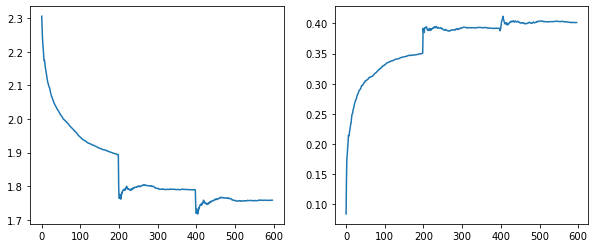

In [35]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(log_loss)
ax[1].plot(log_acc)

In [27]:
# test loss
y_pred = model.forward(Xte)
y_true = onehot(Yte, n_class)
CEloss(y_true, y_pred)

1.749183021359016e+00

In [28]:
# test accuracy
get_accuracy(Yte, y_pred)

0.4001

In [29]:
# training loss (for the entire set)
y_pred = model.forward(Xtr)
y_true = onehot(Ytr, n_class)
CEloss(y_true, y_pred)

1.7403629740541118

In [30]:
# training accuracy
get_accuracy(Ytr, y_pred)

0.40936